In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks')

In [3]:
import pytorch_optimizer as optim

In [4]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [5]:
import torchvision.datasets
from tqdm import tqdm
import pandas as pd

In [6]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [7]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [8]:
len(y_train), len(y_test)

(50000, 10000)

In [9]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [10]:
X_train /= 255.
X_test /= 255.

In [ ]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

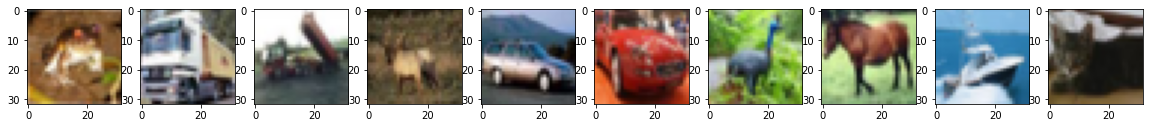

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [12]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [13]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [14]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [25]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=1.0e-2)
    #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)
    #optimizer = optim.PNMBelief(net.parameters(), lr=0.001)
    #optimizer = optim.YogiPNM(net.parameters(), lr=0.001)
    #optimizer = optim.AdaBelief(net.parameters())
    #optimizer = optim.DiffGrad(net.parameters())
    #optimizer = optim.Yogi(net.parameters())
    
    batch_size = 200

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(20):
        print("epoch ", epoch)
        order = np.random.permutation(len(X_train))
        
        #if epoch == 15:
            #print("lr=1.0e-4")
            #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)
            #optimizer = optim.PNMBelief(net.parameters(), lr=1.0e-4)
            #optimizer = optim.YogiPNM(net.parameters(), lr=1.0e-4)


        for start_index in tqdm(range(0, len(X_train), batch_size)):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            #print(test_preds.argmax(dim=1))
            #print(y_test)

        print("accuracy = ", accuracy)
        print("\n\n")
    
    del net

    return test_accuracy_history, test_loss_history

In [16]:
accuracies = {}
losses = {}

In [17]:
from torchvision.models import vgg16, VGG16_Weights
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
accuracies['vgg16+Yogi'], losses['vgg16+Yogi'] = \
    train(model, X_train, y_train, X_test, y_test)

In [26]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+SGD'], losses['vgg16+SGD'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:41<00:00,  6.09it/s]


accuracy =  0.715399980545044



epoch  1


100%|██████████| 250/250 [00:40<00:00,  6.17it/s]


accuracy =  0.7788999676704407



epoch  2


100%|██████████| 250/250 [00:40<00:00,  6.14it/s]


accuracy =  0.8087999820709229



epoch  3


100%|██████████| 250/250 [00:40<00:00,  6.17it/s]


accuracy =  0.8264999985694885



epoch  4


100%|██████████| 250/250 [00:40<00:00,  6.15it/s]


accuracy =  0.8259999752044678



epoch  5


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.837399959564209



epoch  6


100%|██████████| 250/250 [00:40<00:00,  6.14it/s]


accuracy =  0.8499999642372131



epoch  7


100%|██████████| 250/250 [00:40<00:00,  6.14it/s]


accuracy =  0.8536999821662903



epoch  8


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8551999926567078



epoch  9


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8553999662399292



epoch  10


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8463000059127808



epoch  11


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.85589998960495



epoch  12


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8572999835014343



epoch  13


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8557999730110168



epoch  14


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8447999954223633



epoch  15


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8621999621391296



epoch  16


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8634999990463257



epoch  17


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8659999966621399



epoch  18


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8611999750137329



epoch  19


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


accuracy =  0.8607999682426453





In [22]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+Adam'], losses['vgg16+Adam'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:49<00:00,  5.00it/s]


accuracy =  0.7895999550819397



epoch  1


100%|██████████| 250/250 [00:49<00:00,  5.05it/s]


accuracy =  0.8417999744415283



epoch  2


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


accuracy =  0.8572999835014343



epoch  3


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


accuracy =  0.8622999787330627



epoch  4


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


accuracy =  0.861799955368042



epoch  5


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


accuracy =  0.8646999597549438



epoch  6


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


accuracy =  0.8568999767303467



epoch  7


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


accuracy =  0.8657000064849854



epoch  8


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


accuracy =  0.8718000054359436



epoch  9


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


accuracy =  0.8641999959945679



epoch  10


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8590999841690063



epoch  11


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8664000034332275



epoch  12


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8695999979972839



epoch  13


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8655999898910522



epoch  14


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8722999691963196



epoch  15


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8657999634742737



epoch  16


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8770999908447266



epoch  17


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8746999502182007



epoch  18


100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


accuracy =  0.8673999905586243



epoch  19


100%|██████████| 250/250 [00:49<00:00,  5.05it/s]


accuracy =  0.8732999563217163





In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+PNMBelief'], losses['vgg16+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


accuracy =  0.16089999675750732



epoch  1


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


accuracy =  0.11549999564886093



epoch  2


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


accuracy =  0.1938999891281128



epoch  3


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.30640000104904175



epoch  4


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.3206999897956848



epoch  5


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.382099986076355



epoch  6


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.37539997696876526



epoch  7


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.5040000081062317



epoch  8


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.5521999597549438



epoch  9


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.5586999654769897



epoch  10


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.6671000123023987



epoch  11


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.7008999586105347



epoch  12


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.7479000091552734



epoch  13


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.7547999620437622



epoch  14


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.7527999877929688



epoch  15


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.8007999658584595



epoch  16


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.7949000000953674



epoch  17


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.8104999661445618



epoch  18


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.809499979019165



epoch  19


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


accuracy =  0.8331999778747559





In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+YogiPNM'], losses['vgg16+YogiPNM'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:59<00:00,  4.22it/s]


accuracy =  0.3005000054836273



epoch  1


100%|██████████| 250/250 [00:58<00:00,  4.26it/s]


accuracy =  0.48169997334480286



epoch  2


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.5734999775886536



epoch  3


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.758899986743927



epoch  4


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.7646999955177307



epoch  5


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8385999798774719



epoch  6


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8179000020027161



epoch  7


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8274999856948853



epoch  8


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.8346999883651733



epoch  9


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8580999970436096



epoch  10


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.839199960231781



epoch  11


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8690999746322632



epoch  12


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8662999868392944



epoch  13


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.8610999584197998



epoch  14


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8596999645233154



epoch  15


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.863099992275238



epoch  16


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.863599956035614



epoch  17


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8583999872207642



epoch  18


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.868399977684021



epoch  19


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8703999519348145





In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+AdaBelief'], losses['vgg16+AdaBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


accuracy =  0.7906000018119812



epoch  1


100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


accuracy =  0.8123999834060669



epoch  2


100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


accuracy =  0.8055999875068665



epoch  3


100%|██████████| 250/250 [00:55<00:00,  4.52it/s]


accuracy =  0.8481000065803528



epoch  4


100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


accuracy =  0.8592999577522278



epoch  5


100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


accuracy =  0.8216999769210815



epoch  6


100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


accuracy =  0.8411999940872192



epoch  7


100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


accuracy =  0.8504999876022339



epoch  8


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


accuracy =  0.8690999746322632



epoch  9


100%|██████████| 250/250 [00:55<00:00,  4.55it/s]


accuracy =  0.851099967956543



epoch  10


100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


accuracy =  0.8410999774932861



epoch  11


100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


accuracy =  0.8551999926567078



epoch  12


100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


accuracy =  0.854699969291687



epoch  13


100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


accuracy =  0.8406999707221985



epoch  14


100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


accuracy =  0.8252999782562256



epoch  15


100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


accuracy =  0.8409000039100647



epoch  16


100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


accuracy =  0.8118000030517578



epoch  17


100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


accuracy =  0.8191999793052673



epoch  18


100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


accuracy =  0.8351999521255493



epoch  19


100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


accuracy =  0.8376999497413635





In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+DiffGrad'], losses['vgg16+DiffGrad'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:59<00:00,  4.21it/s]


accuracy =  0.6692999601364136



epoch  1


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.7928999662399292



epoch  2


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.8021999597549438



epoch  3


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.8392999768257141



epoch  4


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.8547999858856201



epoch  5


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.8534999489784241



epoch  6


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8447999954223633



epoch  7


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8648999929428101



epoch  8


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8680999875068665



epoch  9


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8667999505996704



epoch  10


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


accuracy =  0.8580999970436096



epoch  11


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8543999791145325



epoch  12


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8596000075340271



epoch  13


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8522999882698059



epoch  14


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8633999824523926



epoch  15


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8520999550819397



epoch  16


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


accuracy =  0.8517999649047852



epoch  17


100%|██████████| 250/250 [00:58<00:00,  4.26it/s]


accuracy =  0.8639000058174133



epoch  18


100%|██████████| 250/250 [00:58<00:00,  4.26it/s]


accuracy =  0.8574000000953674



epoch  19


100%|██████████| 250/250 [00:58<00:00,  4.26it/s]


accuracy =  0.8596000075340271





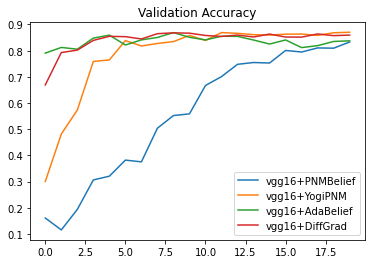

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
    plt.legend()
    plt.title('Validation Accuracy');

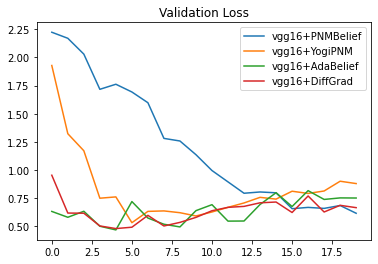

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
    plt.legend()
    plt.title('Validation Loss');

In [ ]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds = model.forward(X_test)

In [ ]:
for x, y in zip(test_preds.argmax(dim=1).tolist(), y_test.tolist()):
    D[y][x] += 1

In [ ]:
D